## This notebook briefly documents how we aggregated the CAPRA vulnerability functions to the BEM classes

- We accessed the CAPRA TC impact functions. However, these are more detailed than the information within BEM.
- Thus we aggregated the to 72 BEM classes
- For the aggregation, we first approximate the individual functions with a sigmoid type function (emanuel curve), then we draw the median of the parameters for each class if there are several CAPRA functions that fall within that class. The min-max range allows us to keep some uncertainty.
- This allows us for a cheap way forward without much data handeling


In [3]:
#%% load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
#%% import data
DP = Path('/Users/sam/Library/CloudStorage/OneDrive-ETHZurich/UNU/Data/CAPRA_TC_impf/')
# load excel file
id_file = pd.read_excel(DP.joinpath('IF_TC_HAZUS_id.xlsx'), sheet_name='Sheet1')
tag_file = pd.read_excel(DP.joinpath('IF_TC_HAZUS_tag.xlsx'), sheet_name='Sheet1')
tag_file = tag_file.dropna(subset=['id'])
struc_sys_uni = tag_file.structural_sys.unique()

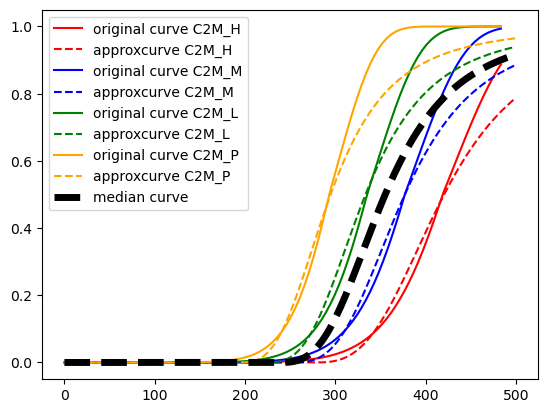

In [7]:

def sig_emanuel(x, v_thresh, v_half):
    v_temp = (x - v_thresh) / (v_half - v_thresh)
    v_temp[v_temp < 0] = 0
    y = v_temp**3 / (1 + v_temp**3)
    return y
cc = tag_file[tag_file['structural_sys'] == 'C2']['tag'].unique()
cols = ['red', 'blue', 'green', 'orange']
v_halfs = np.zeros(len(cc))
v_threshs = np.zeros(len(cc))
xx = np.arange(0, 500, 1)

for t, tag in enumerate(cc):
    impf = pd.read_excel(DP.joinpath('output/'+str(tag)+'.xlsx'), sheet_name='Sheet1')

    inten = impf.iloc[:,0]
    mdd = impf.iloc[:,1]
    v_halfs[t] = inten[np.argmin(np.abs(mdd - 0.5))]
    v_threshs[t] = inten[np.argmax(mdd > 0.01)]

    plt.plot(inten, mdd, color=cols[t], label='original curve'+ ' '+str(tag))

    yy = sig_emanuel(xx, v_threshs[t], v_halfs[t])
    plt.plot(xx,yy, color=cols[t], linestyle='dashed', label='approxcurve'+ ' '+str(tag))

y_main = sig_emanuel(xx, np.median(v_threshs), np.median(v_halfs))
plt.plot(xx, y_main, color='black', linestyle='dashed', linewidth=5, label='median curve')
plt.legend()
plt.show()

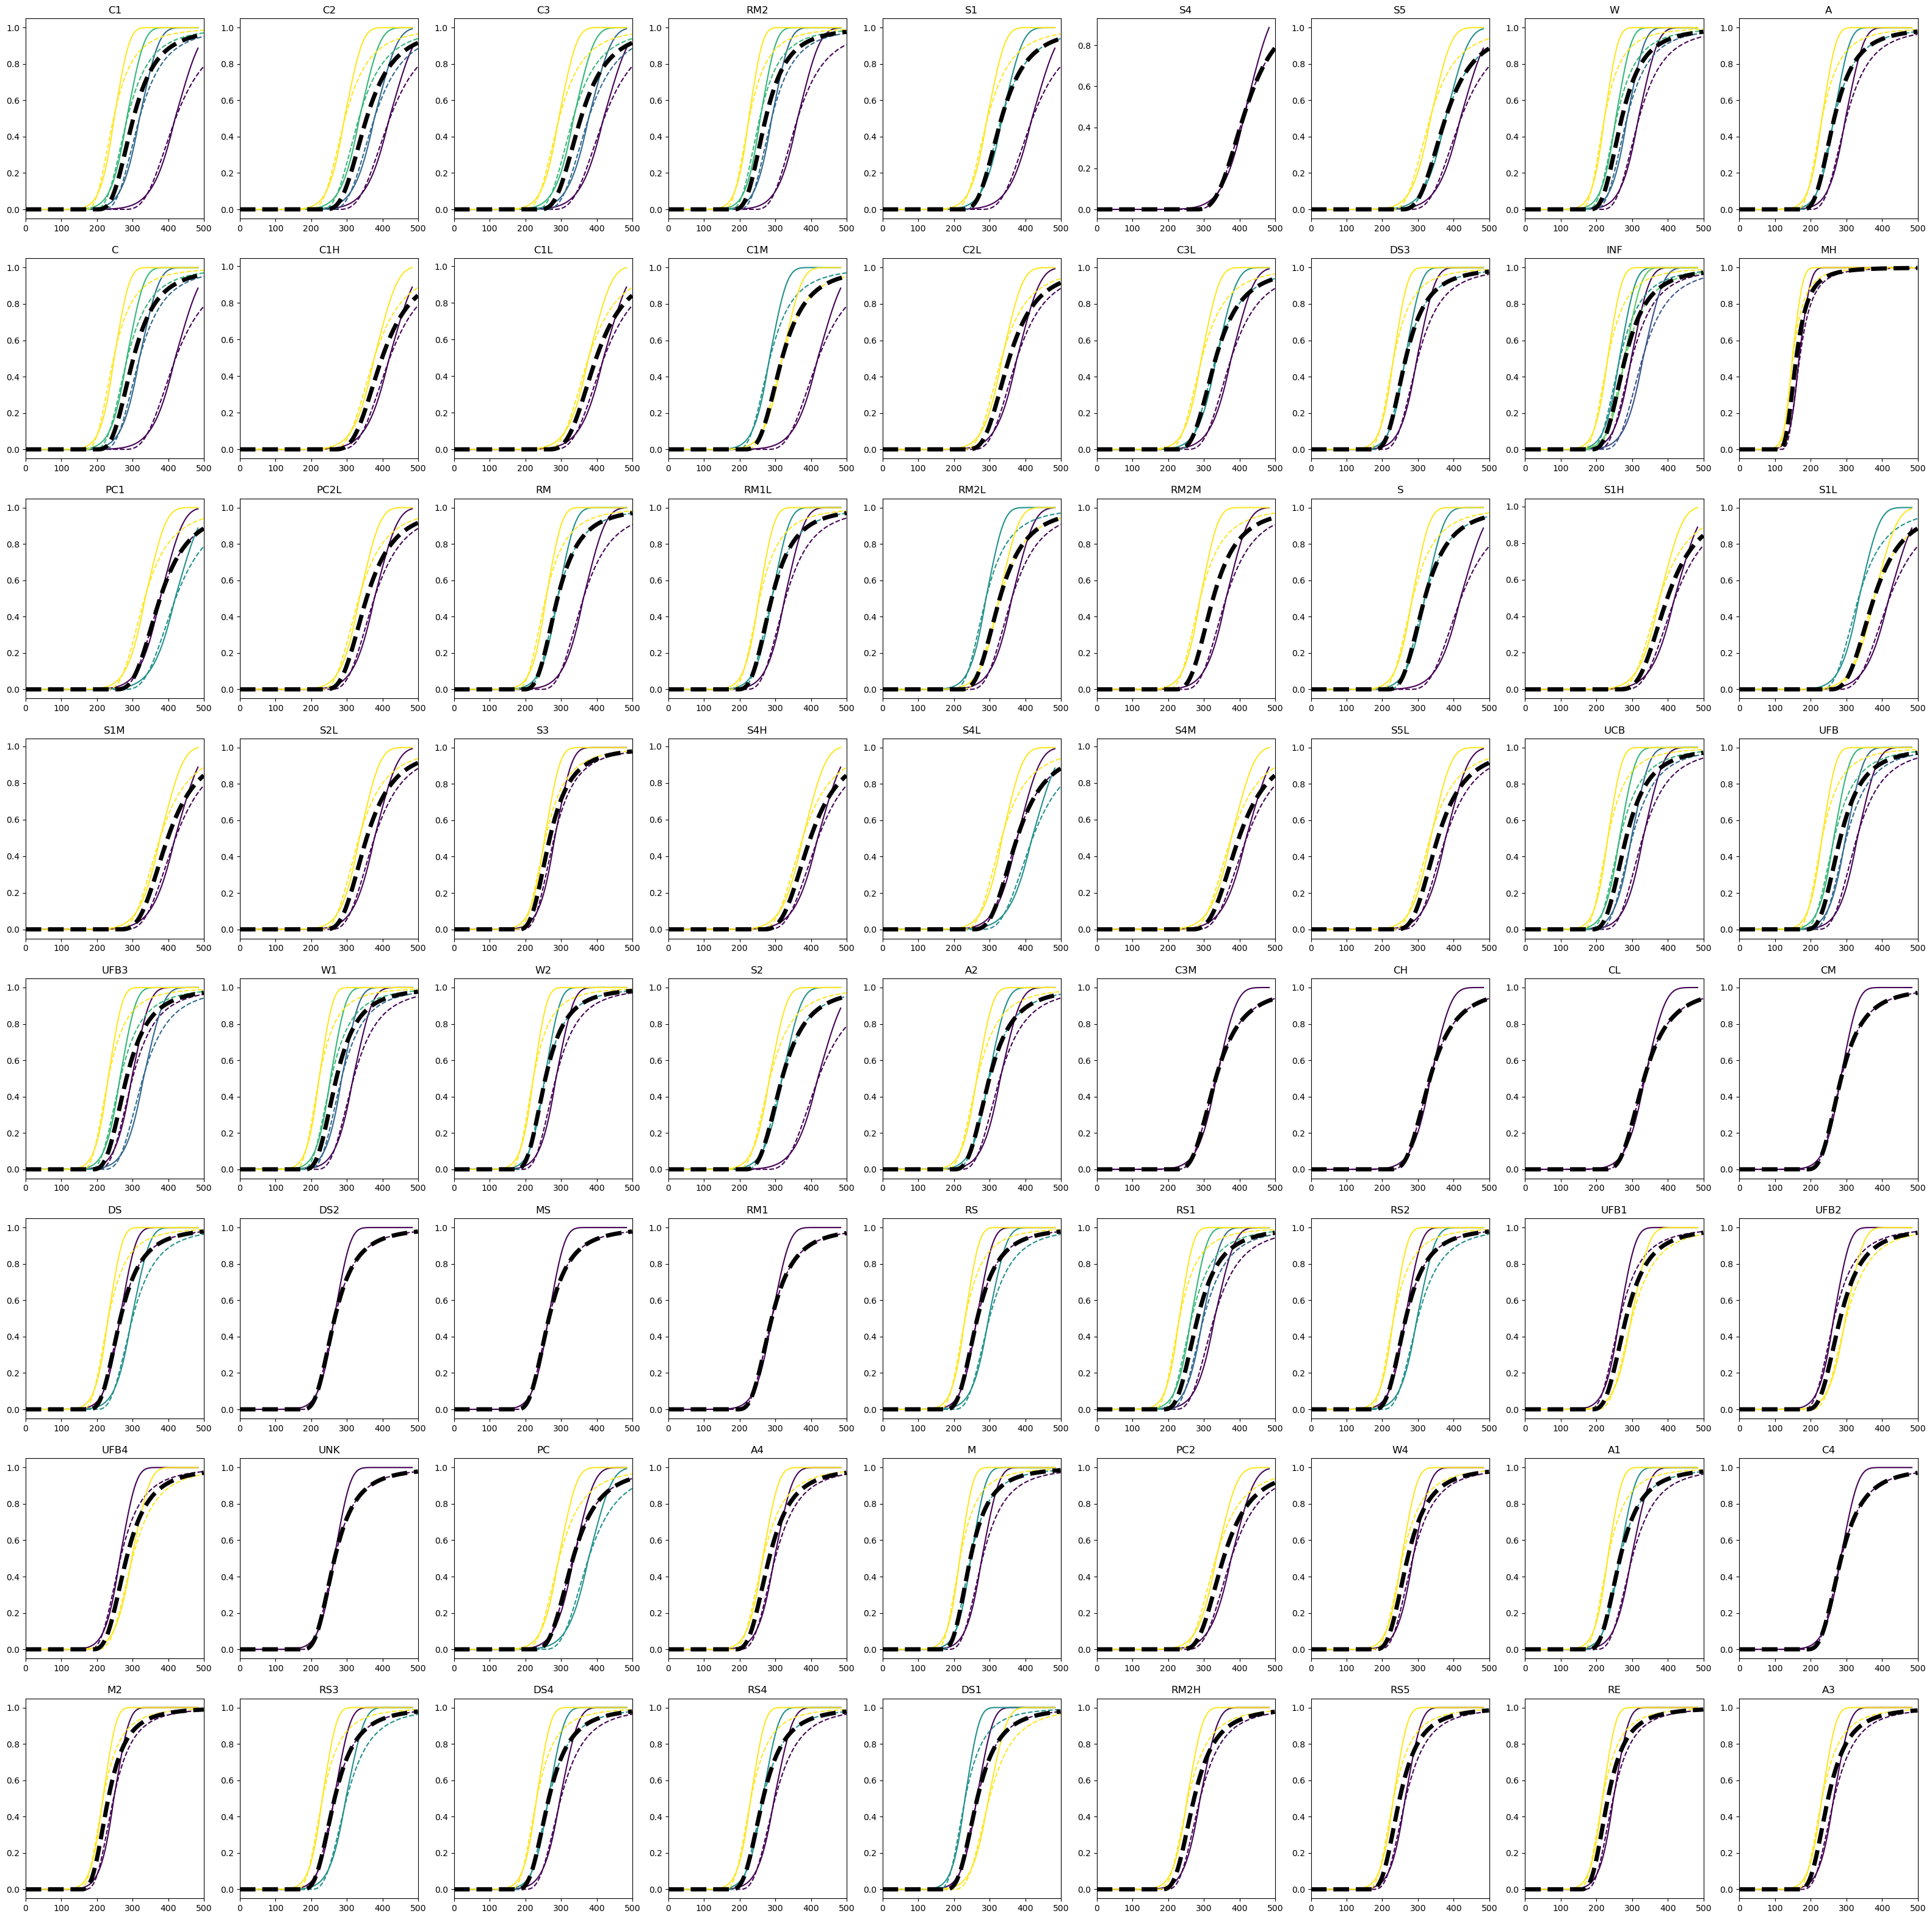

In [6]:
v_halfs_agg_median = np.zeros(len(struc_sys_uni))
v_threshs_agg_median = np.zeros(len(struc_sys_uni))
v_halfs_agg_max = np.zeros(len(struc_sys_uni))
v_threshs_agg_max = np.zeros(len(struc_sys_uni))
v_halfs_agg_min = np.zeros(len(struc_sys_uni))
v_threshs_agg_min = np.zeros(len(struc_sys_uni))

fig, ax = plt.subplots(figsize=(40,40))
grid = plt.GridSpec(8, 9) # create a grid for the subplots

for i in range(len(struc_sys_uni)):
    cc = tag_file[tag_file['structural_sys'] == struc_sys_uni[i]]
    cc_uni = cc['tag'].unique()

    # make viridis color scale with number of tags
    cols = plt.cm.viridis(np.linspace(0, 1, len(cc_uni)))
    v_halfs = np.zeros(len(cc_uni))
    v_threshs = np.zeros(len(cc_uni))
    xx = np.arange(0, 500, 1)

    if i < 9:
        ax = plt.subplot(grid[0,i])
    elif i < 18:
        ax = plt.subplot(grid[1,i-9])
    elif i < 27:
        ax = plt.subplot(grid[2,i-18])
    elif i < 36:
        ax = plt.subplot(grid[3,i-27])
    elif i < 45:
        ax = plt.subplot(grid[4,i-36])
    elif i < 54:
        ax = plt.subplot(grid[5,i-45])
    elif i < 63:
        ax = plt.subplot(grid[6,i-54])
    elif i < 72:
        ax = plt.subplot(grid[7,i-63])

    for t, tag in enumerate(cc_uni):
        impf = pd.read_excel(DP.joinpath('output/'+str(tag)+'.xlsx'), sheet_name='Sheet1')

        inten = impf.iloc[:,0]
        mdd = impf.iloc[:,1]
        v_halfs[t] = inten[np.argmin(np.abs(mdd - 0.5))]
        v_threshs[t] = inten[np.argmax(mdd > 0.01)]

        plt.plot(inten, mdd, color=cols[t])

        yy = sig_emanuel(xx, v_threshs[t], v_halfs[t])
        ax.plot(xx,yy, color=cols[t], linestyle='dashed')

    v_halfs_agg_median[i] = np.median(v_halfs)
    v_threshs_agg_median[i] = np.median(v_threshs)
    v_halfs_agg_max[i] = np.max(v_halfs)
    v_threshs_agg_max[i] = np.max(v_threshs)
    v_halfs_agg_min[i] = np.min(v_halfs)
    v_threshs_agg_min[i] = np.min(v_threshs)

    y_main = sig_emanuel(xx, np.median(v_threshs), np.median(v_halfs))

    

    ax.plot(xx, y_main, color='black', linestyle='dashed', linewidth=5)
    ax.set_xlim([0, 500])
    ax.set_title(struc_sys_uni[i])
plt.show()

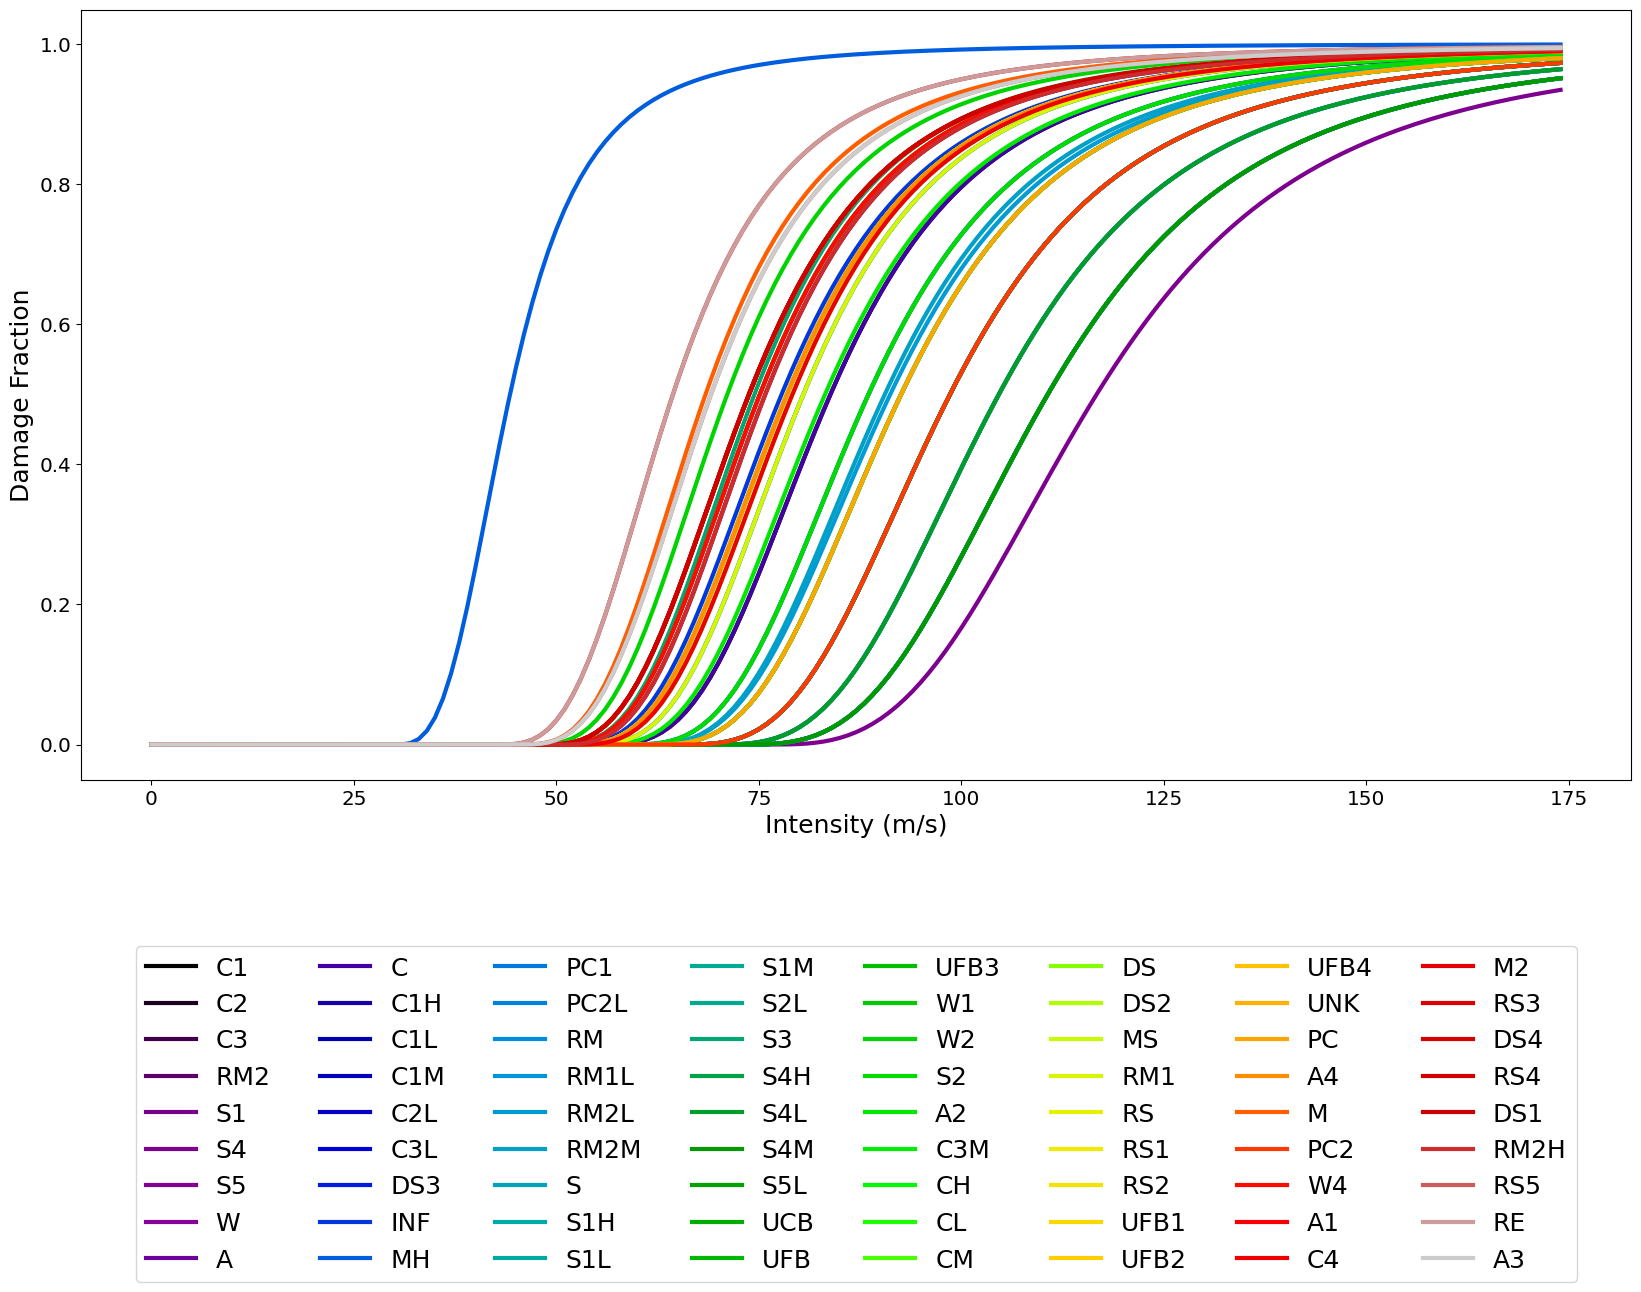

In [8]:
# express everything as m/s instead of km/h
v_halfs_agg_median_ms = v_halfs_agg_median / 3.6
v_threshs_agg_median_ms = v_threshs_agg_median / 3.6
v_halfs_agg_max_ms = v_halfs_agg_max / 3.6
v_threshs_agg_max_ms = v_threshs_agg_max / 3.6
v_halfs_agg_min_ms = v_halfs_agg_min / 3.6
v_threshs_agg_min_ms = v_threshs_agg_min / 3.6

# plot all main curves in one plot
fig, ax = plt.subplots(figsize=(20,10))

xx = np.arange(0, 175, 1)
cols = plt.cm.nipy_spectral(np.linspace(0, 1, len(struc_sys_uni)))
fontsize = 18

for i in range(len(struc_sys_uni)):
    y_main = sig_emanuel(xx, v_threshs_agg_median_ms[i], v_halfs_agg_median_ms[i])
    ax.plot(xx, y_main, label=struc_sys_uni[i], color=cols[i], linewidth=3)
# add legend
# legend with 8 columns
ax.legend(fontsize=fontsize, ncol=8, bbox_to_anchor=(0.5, -0.2), loc='upper center')
ax.set_xlabel('Intensity (m/s)', fontsize=fontsize)
ax.set_ylabel('Damage Fraction', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize*0.8)
plt.show()

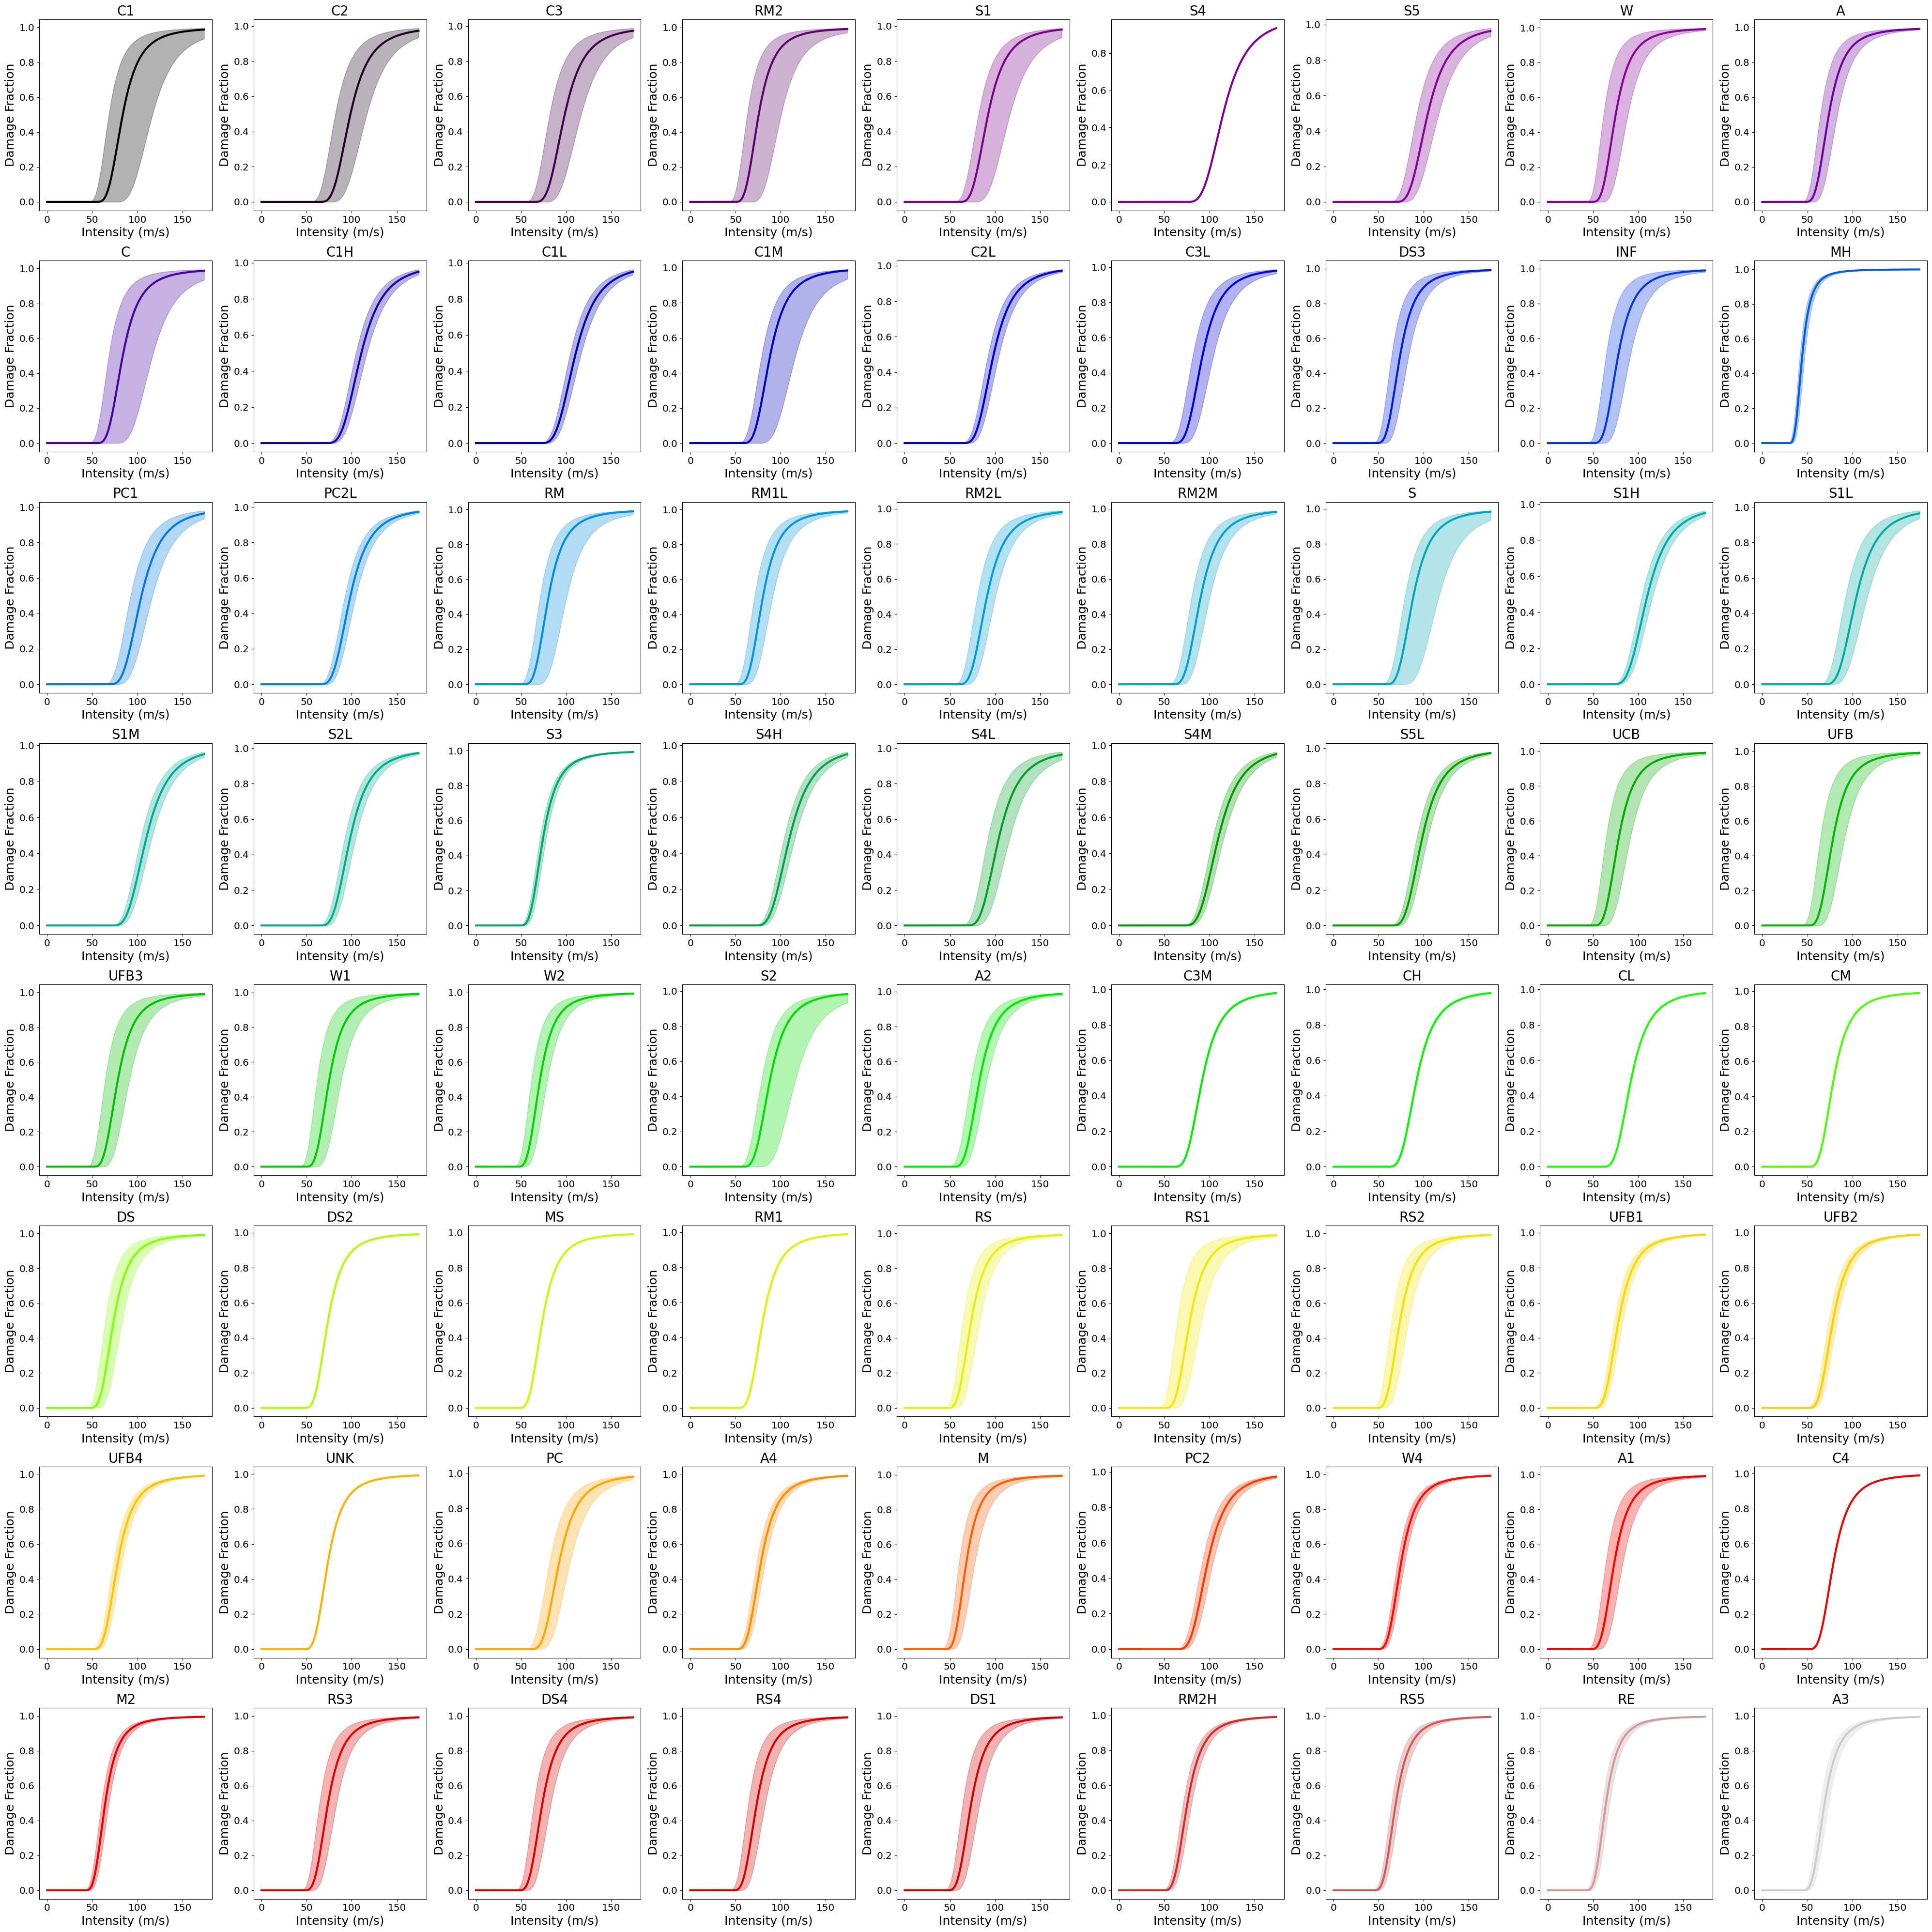

In [9]:

fig, ax = plt.subplots(figsize=(40,40))
grid = plt.GridSpec(8, 9) # create a grid for the subplots
for i in range(len(struc_sys_uni)):
    if i < 9:
        ax = plt.subplot(grid[0,i])
    elif i < 18:
        ax = plt.subplot(grid[1,i-9])
    elif i < 27:
        ax = plt.subplot(grid[2,i-18])
    elif i < 36:
        ax = plt.subplot(grid[3,i-27])
    elif i < 45:
        ax = plt.subplot(grid[4,i-36])
    elif i < 54:
        ax = plt.subplot(grid[5,i-45])
    elif i < 63:
        ax = plt.subplot(grid[6,i-54])
    elif i < 72:
        ax = plt.subplot(grid[7,i-63])
    y_main = sig_emanuel(xx, v_threshs_agg_median_ms[i], v_halfs_agg_median_ms[i])
    y_low = sig_emanuel(xx, v_threshs_agg_min_ms[i], v_halfs_agg_min_ms[i])
    y_high = sig_emanuel(xx, v_threshs_agg_max_ms[i], v_halfs_agg_max_ms[i])
    ax.plot(xx, y_main, label=struc_sys_uni[i], color=cols[i], linewidth=3)
    ax.fill_between(xx, y_low, y_high, color=cols[i], alpha=0.3)
    ax.set_title(struc_sys_uni[i], fontsize=fontsize*1.1)
    ax.set_xlabel('Intensity (m/s)', fontsize=fontsize)
    ax.set_ylabel('Damage Fraction', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize*0.8)
# arange for enough space between subplots
plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame({'building_type':struc_sys_uni,
                    'v_half_median':v_halfs_agg_median_ms,
                    'v_thresh_median':v_threshs_agg_median_ms,
                    'v_half_max':v_halfs_agg_max_ms,
                    'v_thresh_max':v_threshs_agg_max_ms,
                    'v_half_min':v_halfs_agg_min_ms,
                    'v_thresh_min':v_threshs_agg_min_ms})
df.to_csv(DP.joinpath('CAPRA_TO_BEM_TC_WIND_IMPACT_FUNCTIONS.csv'))